In [139]:
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import sys
import numpy as np
import pandas as pd
import re
import requests
import lxml
from lxml.html.soupparser import fromstring
import numbers
import re
import seaborn as sns
import matplotlib.pyplot as plt

def get_responses_from_zipcode(zipcode=None, max_page_limit = 20):
    # pass in zipcode
    if zipcode is None:
        return None
    req_headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.8',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
    }
    responses_per_zipcode = []
    with requests.Session() as s:
        #url = 'https://www.zillow.com/homes/for_rent/'+ city + '/'
        #url = "https://www.zillow.com/homes/for_rent/95133_rb"
        #url = "https://www.zillow.com/homes/for_rent/{0}/0_singlestory/pricea_sort".format(zipcode)
        #url = "https://www.zillow.com/homes/for_rent/{0}_rb/?fromHomePage=true&shouldFireSellPageImplicitClaimGA=false&fromHomePageTab=buy".format(zipcode)
        url = "https://www.zillow.com/homes/for_rent/{0}/0_singlestory/".format(zipcode)
        print(url)
        r = s.get(url, headers=req_headers)
        responses_per_zipcode.append(r)
        
        total_pages = get_total_pages(r.text)
        print("total pages to work on for zipcode {0} is {1}".format(zipcode, total_pages))
        for i in range(2, min(total_pages, max_page_limit) + 1):
            cur_url = 'https://www.zillow.com/homes/for_rent/{0}/0_singlestory/{1}_p'.format(zipcode, i)
            print(cur_url)
            cur_resp = s.get(cur_url, headers=req_headers)
            responses.append(cur_resp)
    return responses_per_zipcode

def get_price(string = None):
    if string is None:
        return None
    pattern = '"price":([0-9]+)'
    return [int(x) for x in re.findall(pattern, string)]

def get_days_on_zillow(string = None):
    if string is None:
        return None
    pattern = '"daysOnZillow":([0-9]+)'
    return [int(x) for x in re.findall(pattern, string)]

def get_home_size(string = None):
    if string is None:
        return None
    pattern = '"area":([0-9]+)'
    return [int(x) for x in re.findall(pattern, string)]

def get_home_city(string = None):
    if string is None:
        return None
    pattern = '"addressCity":("[A-Za-z\s]+")'
    return re.findall(pattern, string)

def get_home_state(string = None):
    if string is None:
        return None
    pattern = '"addressState":("[A-Z]+")'
    return re.findall(pattern, string)

def get_home_type(string = None):
    if string is None:
        return None
    pattern = '"homeType":("[A-Za-z\s_]+")'
    return re.findall(pattern, string)

def get_home_link(string = None):
    if string is None:
        return None
    pattern = '"detailUrl":("https:[a-zA-Z.\/:0-9-_]+")'
    return re.findall(pattern, string)

def get_bed_rooms(string = None):
    if string is None:
        return None
    pattern = '"bedrooms":([0-9]+)'
    return [int(x) for x in re.findall(pattern, string)]

def get_bath_rooms(string = None):
    if string is None:
        return None
    pattern = '"bathrooms":([0-9]+)'
    return [int(x) for x in re.findall(pattern, string)]

def get_total_pages(string = None):
    if string is None:
        return None
    pattern = '"totalPages":([0-9]+)'
    l = re.findall(pattern, string)
    return int(l[0]) if l else 1

In [146]:
####################
zip_codes = ['95133','95014','95132','95131','95134','78641','78613','78762', '27511','27512','27513','27518']
zip_codes = ['78641','78613','78717','78727', '27511','27512','27513','27518','27502','27523','27540']
zip_codes = ['San Jose', 'Austin', 'Cary','Houston','Dallas','Round Rock']
###################

## MAKE API Calls to Zillow to get data
df_all = pd.DataFrame()
responses = []
for zipcode in zip_codes:
    responses += get_responses_from_zipcode(zipcode, 15) 

https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/
total pages to work on for zipcode San Jose is 20
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/2_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/3_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/4_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/5_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/6_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/7_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/8_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/9_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/10_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/11_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/12_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/13_p
https://www.zillow.com/homes/for_rent/San Jose/0_singlestory/14_p
https://www.zillow.com/homes/for_rent/

In [153]:
df_all=pd.DataFrame()
for r in responses:
    string = r.text
    df = pd.DataFrame()
    df['days_on_zillow'] = pd.Series(get_days_on_zillow(string)) #Series
    df['bed_rooms'] = pd.Series(get_bed_rooms(string))
    df['bath_rooms'] = pd.Series(get_bath_rooms(string))
    df['city'] = pd.Series(get_home_city(string))
    df['state'] = pd.Series(get_home_state(string))
    df['price'] = pd.Series(get_price(string))
    df['home_type'] = pd.Series(get_home_type(string))
    df['home_link'] = pd.Series(get_home_link(string))
    df['total_pages'] = pd.Series([get_total_pages(string)]*len(get_days_on_zillow(string)))
    df_all=df_all.append(df,ignore_index=True).dropna()

/Library/Python/3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/Library/Python/3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Library/Python/3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/Library/Python/3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/Library/Python/3.7/sit

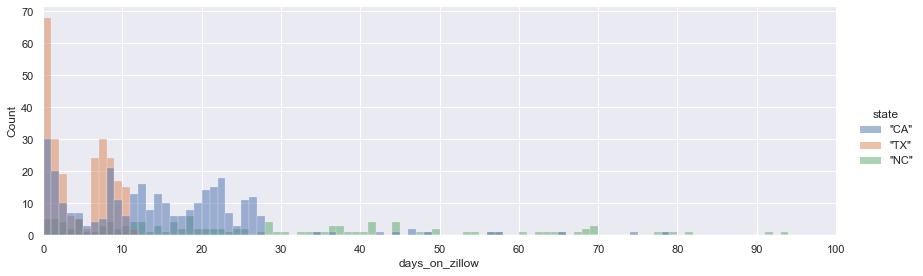

In [164]:
ax = sns.displot(df_all[df_all['home_type'] != '"APARTMENT"'], 
            x="days_on_zillow", 
            hue="state", 
            #stat="density",
            binwidth = 1,
            height = 4, 
            aspect = 3)
ax.set(xlim=(0,100), xticks=[x for x in range(0,110,10)])

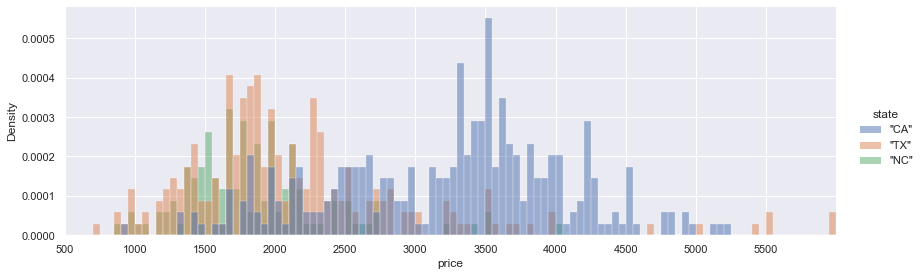

In [165]:
ax = sns.displot(df_all[df_all['home_type'] != '"APARTMENT"'], 
            x="price", 
            hue="state", 
            stat="density",
            binwidth = 50,
            height = 4, 
            aspect = 3)
ax.set(xlim=(500,6000), xticks=[x for x in range(500,6000,500)])

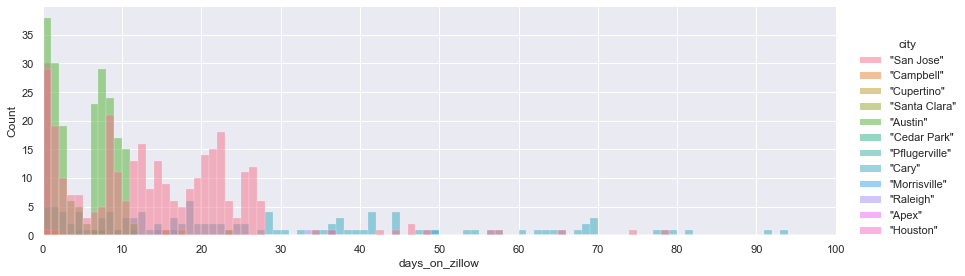

In [166]:
ax = sns.displot(df_all[df_all['home_type'] != '"APARTMENT"'], 
            x="days_on_zillow", 
            hue="city", 
            #stat="density",
            binwidth = 1,
            height = 4, 
            aspect = 3)
ax.set(xlim=(0,100), xticks=[x for x in range(0,110,10)])